# Probabilistic Time Series Forecast

In this example, we will consider how to use conditional generative models for probabilistic time series forecast. The generative models help to estimate confidence intervals of the predictions.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Read data set

We will predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

In [ ]:
# data download
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

In [3]:
# read the data
data = pd.read_csv("airline-passengers.csv")
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## Data visualization

In [4]:
# get a time series
Y = data[['Passengers']].values

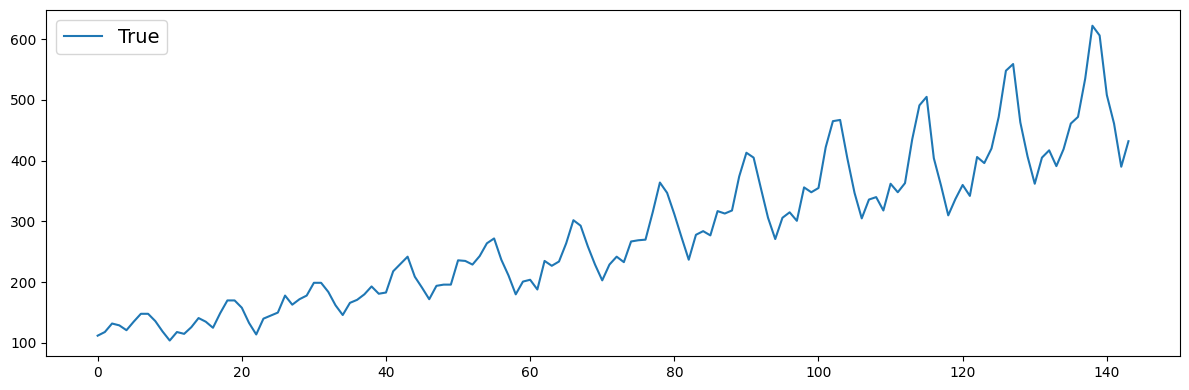

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(Y, label='True')
plt.legend(loc='best', fontsize=14)
plt.tight_layout()
plt.show()

## Preprocessing

In [6]:
# scaling
from sklearn.preprocessing import StandardScaler
Y = StandardScaler().fit_transform(Y)

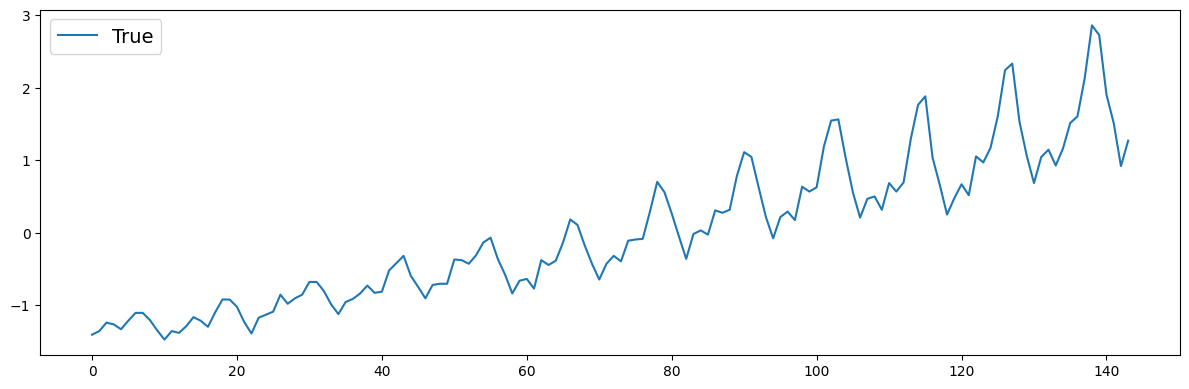

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(Y, label='True')
plt.legend(loc='best', fontsize=14)
plt.tight_layout()
plt.show()

## Autoregression model for time series forecast


Consider $y_1, y_2, ..., y_i, ..., y_N$ are observations of a time series. Autoegression model (AR) for the time series forecast assumes the following:

$$ \hat{y}_{i+m} = f( y_{i}, y_{i-1}, ... y_{i-k+1} ) $$

where $\hat{y}_{i+m}$ is a predicted value.

In matrix form we will define this model as:

$$\hat{Y} = f(X)$$

where
$$X = \left(
\begin{array}{cccc}
y_{k} & y_{k-1} & \ldots & y_{1}\\
\vdots & \vdots & \ddots & \vdots\\
y_{k+j} & y_{k+j-1} & \ldots & y_{j+1}\\
\vdots & \vdots & \ddots & \vdots
\end{array}
\right)$$

$$Y = \left(
\begin{array}{c}
y_{k+m} \\
\vdots\\
y_{k+j+m}\\
\vdots
\end{array}
\right)$$

In [8]:
K = 10
M = 10

In [9]:
def AR_matrices(Y, K, M):
    X_AR = []
    Y_AR = []
    for i in range(len(Y)):
        
        if i < K-1: continue
        if i+M >= len(Y): break
        
        ax_ar = Y[i+1-K:i+1].reshape(-1, )
        X_AR.append(ax_ar)

        ay_ar = Y[i+M]#[0] # predict only y_{i+M}
        # ay_ar = Y[i+1:i+M+1].reshape(-1, ) # predict y_{i+M}, ..., y_{i+2}, y_{i+1}
        Y_AR.append(ay_ar)

    return np.array(X_AR), np.array(Y_AR)

In [10]:
# prepare X and Y matrices
X_AR, Y_AR = AR_matrices(Y, K, M)

In [11]:
X_AR[:2]

array([[-1.40777884, -1.35759023, -1.24048348, -1.26557778, -1.33249593,
        -1.21538918, -1.10664719, -1.10664719, -1.20702441, -1.34922546],
       [-1.35759023, -1.24048348, -1.26557778, -1.33249593, -1.21538918,
        -1.10664719, -1.10664719, -1.20702441, -1.34922546, -1.47469699]])

In [12]:
Y_AR[:2]

array([[-0.9226223 ],
       [-1.02299951]])

In [13]:
X_AR.shape, Y_AR.shape

((125, 10), (125, 1))

## Train and test split

In [14]:
N = 90
X_AR_train, X_AR_test = X_AR[:N], X_AR[N:]
Y_AR_train, Y_AR_test = Y_AR[:N], Y_AR[N:]

## Fit probabilistic model

In [15]:
from probaforms.models import RealNVP

In [16]:
# fit nomalizing flow model
model = RealNVP(lr=0.01, n_epochs=100, weight_decay=0.2)
model.fit(Y_AR_train, X_AR_train)

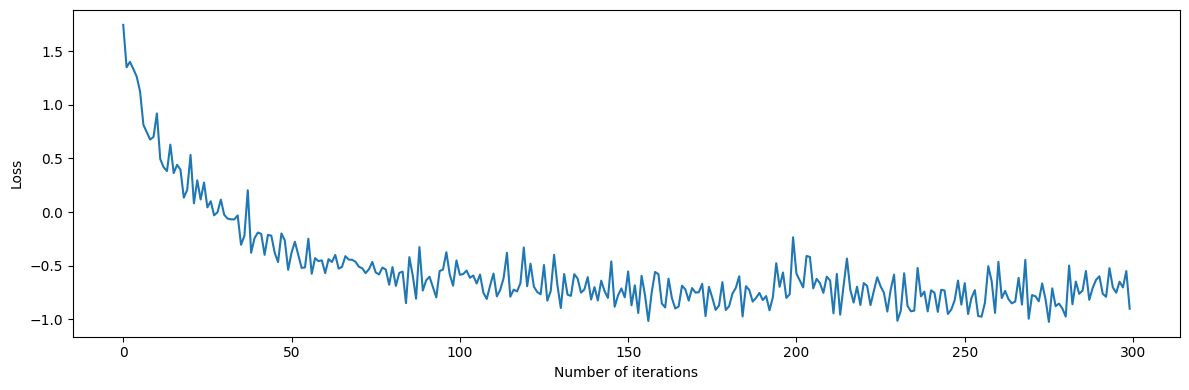

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

## Single prediction

In [18]:
# sample new objects
Y_pred_test = model.sample(X_AR_test)

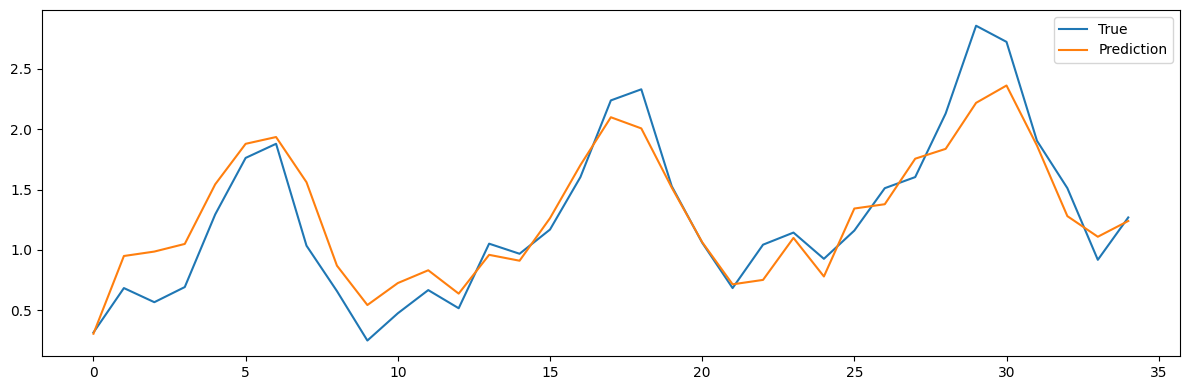

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(Y_AR_test[:, -1], label='True', alpha=1.)
plt.plot(Y_pred_test[:, -1], label='Prediction', alpha=1.)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Multiple predictions

In [20]:
predictions_test = []
for i in range(1000):
    Y_pred_test = model.sample(X_AR_test)
    # store predictions
    predictions_test.append(Y_pred_test[:, -1])
predictions_test = np.array(predictions_test)

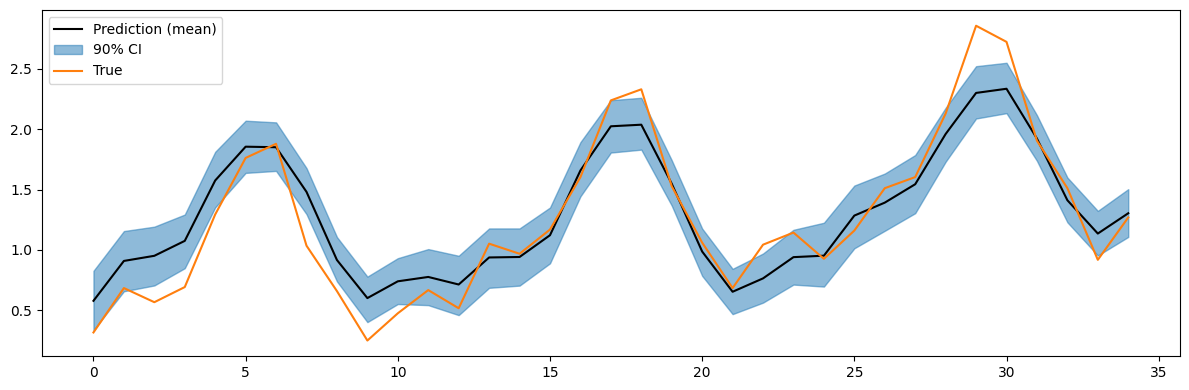

In [21]:
plt.figure(figsize=(12, 4))

# mean prediction
plt.plot(predictions_test.mean(axis=0), label='Prediction (mean)', alpha=1., color='0')

# 90% CI
xx = np.arange(len(Y_pred_test))
y_top = np.quantile(predictions_test, q=0.95, axis=0)
y_bot = np.quantile(predictions_test, q=0.05, axis=0)
plt.fill_between(xx, y_bot, y_top, label="90% CI", alpha=0.5, color='C0')

# true
plt.plot(Y_AR_test[:, -1], label='True', alpha=1., color='C1')
plt.legend(loc='best')
plt.tight_layout()
plt.show()